In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gmt import Interval,Ball, Cube, plot_cube, plot_cubes


In [3]:
def get_random_points(m,mu,sigma):
    X = np.random.multivariate_normal(np.array(mu),cov=np.array([[sigma,0],[0,sigma]]), size=m)
    X = np.array([x for x in X if np.max(np.absolute(x-np.array([.5,.5])))<=.45])
    return X

def default(ax):
    ax.set_xlim([-.01,1.01])
    ax.set_ylim([-.01,1.01])
    ax.set_aspect("equal")
    ax.axis("off")
    return ax




    

In [4]:

#Returns interval of generation n containing point
def covering_interval(x,n):
    a = (x * (2**n) // 1) * (2**(-n))
    return Interval([a,a+2**(-n)])

#Returns intervals of generation n covering set of points
def get_interval_cover(X,n):
    return {covering_interval(x,n) for x in X}

#Returns cube of generation n containing point   
def covering_cube(x,n):
    return Cube([covering_interval(coordinate,n) for coordinate in x])

#Returns cube of generation n covering set of points
def get_cube_cover(X,n):
    return {covering_cube(x,n) for x in X}

get_cube_cover([[.1,.1], [.6,.6]],3)

{Cube[[0.0, 0.125], [0.0, 0.125]], Cube[[0.5, 0.625], [0.5, 0.625]]}

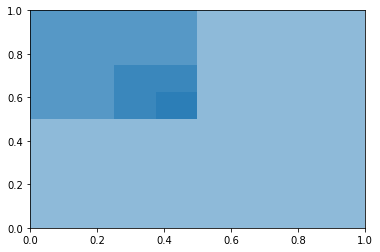

In [5]:
"""
The following function returns a dictionary of lists of cubes in the unit cube, indexed by the level. So for example
tree[0] is a list comprising just of the children cubes, tree[1] are the children of those children, and so on. You 
can specify a depth n that you would like to go and the dimension you're working in, so get_tree_of_cubes(n=2,d=2) 
will return a dictionary called "tree" of lists of 2-dimensional cubes, i.e. squares, so that tree[0] is the top 
square, tree[1] is its children, and tree[2] are the children of those children. If a Nxd numpy array X is provided,
then the dimension is inferred from this array (and set equal to d) and a tree is returned that contains only cubes 
containing points in X.

We won't actually need this localized tree option below, but it could be useful.
"""

def get_tree_of_cubes(n,d=None,X=None):
    if type(X) is np.ndarray:
        d=X.shape[1]
    else:
        assert d>=1 and type(d) is int, "Must specify an integer dimension d unless a list of points X is provided"

    tree = dict()
    unit_square = Cube([[0,1] for _ in range(d)])
    
    for i in range(n+1):
        if type(X) is np.ndarray:
            tree[i] = get_cube_cover(X,i)
            
        else:
            tree[i] = unit_square.descendants(i)
    return tree


"""
As an example, we get three levels of squares that contain the coordinate [.4,.5] and plot them
"""

g = get_tree_of_cubes(3,2,X=np.array([[.4,.5]]))

fig, ax = plt.subplots()
for i in g:
    plot_cubes(list(g[i]), ax=ax, alpha=.5)

The proof for the existence of an s-Frostman measure of level n given a set X goes as follows, we refer to the proof in Mattila's *Geometry of Sets and Measures*.

We define a sequence of measures $\mu_{n}^{k}$ for $k=n,n-1,...,0$, with density given by $f_{m}^{k}dx$ where dx is Lebesgue measure and $f_{n}^{k}$ is some function. Denoting the set of dyadic cubes in the unit cube of sidelength $2^{-k}$ as $\Delta_k$, We start by setting $\mu_{n}^{n}(Q)=\ell(Q)^{s}$ for all $Q\in \Delta_{n}$ that intersect the set X (so $f_{n}^{n}|_{Q} = \mu(Q)/|Q| = 2^{-n(s-d)}$ and zero otherwise (so $f_{n}^{n}|_{Q}=0$). Inductively, if $\mu_{n}^{k+1}=f_{n}^{k+1}dx$ has been defined, for each $Q\in \Delta_{k}$ we set $density(Q) = \min\{1,\ell(Q)^{s}/\mu_{n}^{k+1}(Q)\}$ (with the understanding that dividing by zero is infinity which is bigger than 1, so the density is one in that case) and define $\mu_{n}^{k} = density(Q)\cdot  \mu_{n}^{k+1}$, so $f_{n}^{k}|_{Q} = density(Q) f_{n}^{k+1}|_{Q}$. We repeat this process until we reach $\mu_{n}^{0}$ and $f_{n}^{0}$, and then take a weak limit as $n\rightarrow\infty$. Observe that for a fixed $n$, and $Q\in \Delta_n$ intersecting $X$,

$$f_{m}^{0}dx|_{Q} = density(Q_0)\cdot f_{m}^{1}dx|_{Q} = \cdots = \left(\prod_{k=0}^{n-1} density(Q_k)\right) f_{m}^{m}dx|_{Q} = 2^{n(s-d)}  \left(\prod_{k=0}^{n-1} density(Q_k)\right) .$$

In computing $f_{n}^{0}$ for a specified $n$, we will do this as follows. We wil define a dictionary mu defined on the tree of cubes. In the first instance, it will be defined to be equal to $\ell(Q)^{s}$ for all cubes of sidelength $2^{-n}$ (the sidelength of a cube object is Q.len, so this quantity is written  ```Q.len**s```) that intersect $X$ (we define this to be ```bottom_cubes_over_X``` below). Then iterating over scales i=n-1,n-2,...,0, we perform the following operation:

The cubes of level i are kept as a list in tree[i]. We first define the value of mu(Q) for a cube in tree[i] to be the sum of mu[R] over all its children. If mu(Q) is bigger than $\ell(Q)^{s}$, then we record a correction term in a dictionary, ```density[Q] = Q.len**s / mu[Q]``` and we update the value of mu[Q] again by setting ```mu[Q] = Q.len**s = density[Q]**mu[Q]```; otherwise we leave mu[Q] alone and set ```density[Q]=1``` (that is, no correction is done). We also define the density to be zero on any of the bottom cubes that don't intersect X. 

Once we get to the top of the tree of cubes, or dictionary mu isn't exactly the measure on cubes, since each time we corrected the value of mu on a cube Q, we didn't do so for its descendants. This is so that we can be a bit more efficient; if we adjusted all descendants each time we visited a cube, we could adjust a cube as many as n times. The way we will do it, we will only need to adjust it once after we get to the top. 

We define our density using a dictionary of cubes on the tree, adjusting the values for each cube by defining the f value of the children of a cube Q as the value ```f[Q]*density[Q]```. We work down the tree until we get to the bottom cubes, and the value of f on these bottom cubes gives us our density f according to the equation above. Since we are only concerned with generating illustrations, we will just define our starting value to be 1 for the unit cube.

In [30]:

def frostmann_measure(X,n,s):
    
    d=X.shape[1]
    
    unit_cube = Cube([[0,1] for _ in range(d)])
    
    
    
    tree = get_tree_of_cubes(n,d)
    
    
    
    

    bottom_cubes_over_X = get_cube_cover(X,n)
    
    
    
    unit_cube = Cube([[0,1] for _ in range(d)])
    
    

    #Here we record our density and measure for cubes in the tree.
    density=dict()
    mu = dict()
    #We first define the measure for the bottom squares.
    for Q in tree[n]:
        if Q in bottom_cubes_over_X:
            mu[Q] = Q.len**s
            density[Q]=1
        else:
            density[Q]=0
            mu[Q]=0
    #We start from the bottom of the tree and work upwards
    for i in reversed(range(n)):
        #For each cube in the ith level of the tree, we compute its measure as the sum of the measures of its 
        #children
        for Q in tree[i]:
            mu[Q] = sum([mu[R] for R in Q.children()])
            #If the measure is too big, we record the correction factor density and redefine mu[Q] so that it is 
            #not too big
            if mu[Q] > Q.len**s:
                density[Q] = (Q.len**s)/mu[Q]
                mu[Q] = Q.len**s
            #otherwise, if the measure was positive but not too big, or if it was zero, we don't change the measure and record our
            #correction factor as 1, i.e. no change
            else:
                density[Q] = 1
    
    f={unit_cube:1}
    #The following loop computes the density of f by working its way down the tree of cubes and iteratively
    #computing the product of the densities of nested chains of cubes. The final density f, defined over
    #cubes at the bottom scale, is equal to the product of densities of all cubes containing a given cube. Note that
    #We don't multiply by the top density, but that's ok since the resulting function f will only differ by a constant
    for i in range(n):
        for Q in tree[i]:
            for R in Q.children():
                f[R] = f[Q]*density[R]
                
    return {Q:f[Q] for Q in tree[n]}





We now simulate and graph the density of the frostman measure for a particular set and for three different dimensions, s=.1, 1, 1.5, and 2. 

The set we consider will consist of some points randomly distributed according to a multivariate gaussian distribution near the center of the square, essentially to simulate a ball (which looks 2 dimensional) plus some noise (i.e. many isolated points). Additionally, we'll tack on a line passing through the set, which is distributed in a 1-dimensional way. 

In [35]:
#The following set we will consider is a bunch of points concentrated at the center of the unit square plus some points
#along a line
X = get_random_points(1000,[.5,.5],.01)

X = np.concatenate([X,np.array([[t,1-t] for t in np.arange(.1,.9,.01)])])


Text(0, -0.1, '(b) $2.0$-Frostman Measure')

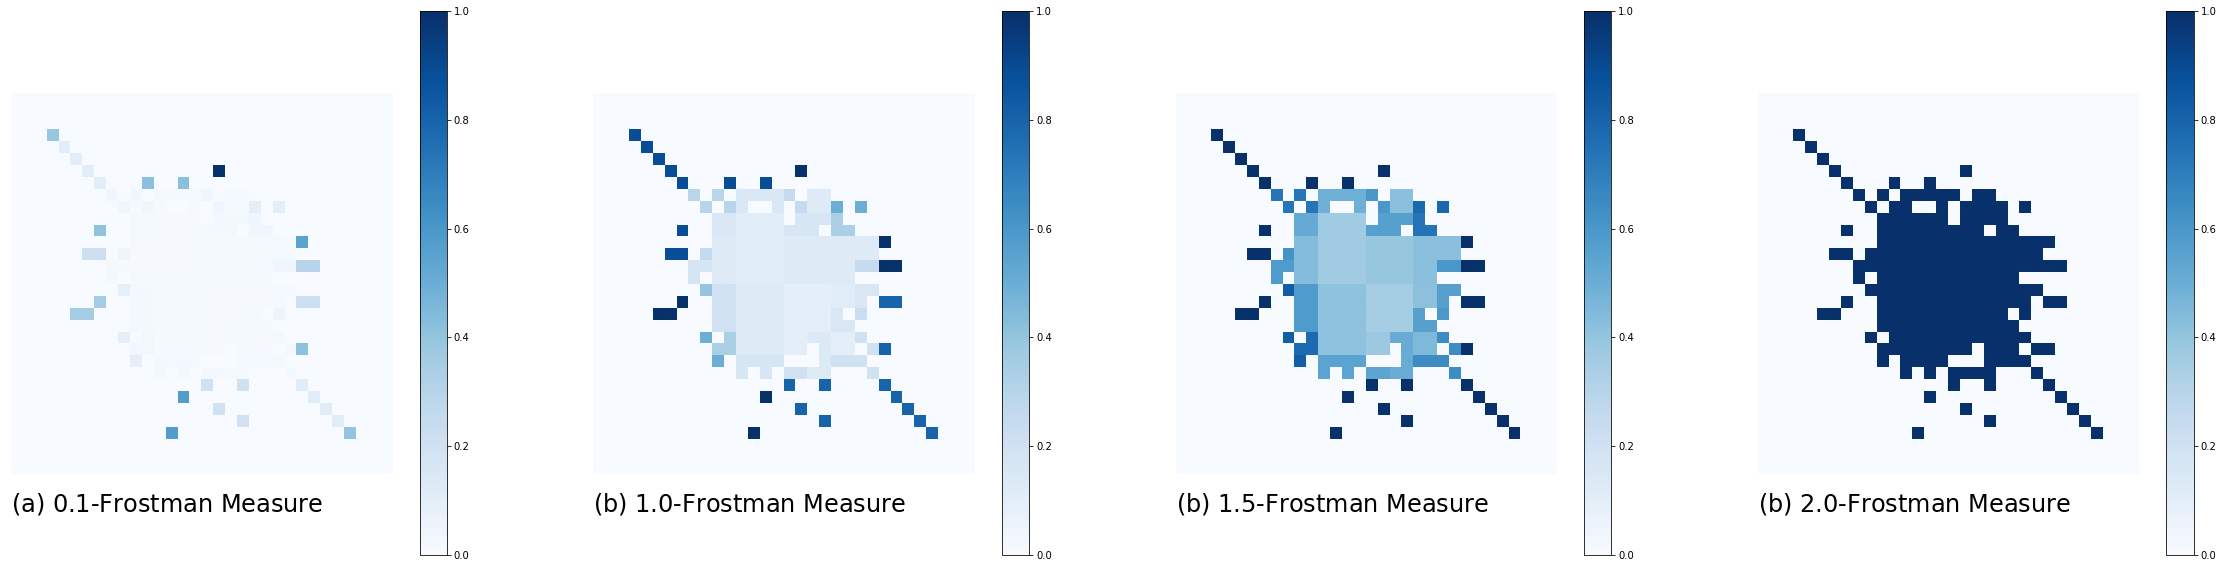

In [42]:
from  matplotlib import colorbar


fig, axes = plt.subplots(1,4, figsize=(40,10))

for ax in axes:
    default(ax)
    
    
cmap=plt.cm.Blues

L = [.1,1,1.5,2]

for i, ax in enumerate(axes):
    
    f = frostmann_measure(X,5,L[i]) 

    cax, _ = colorbar.make_axes(ax) 
    
    cb = colorbar.ColorbarBase(cax, cmap=cmap)

    max_density = max(f.values())

    for Q in f:
        plot_cube(Q, ax=ax, color=cmap(f[Q]/max_density))
    
axes[0].text(0, -.1, r"(a) $0.1$-Frostman Measure", size=24)
axes[1].text(0,-.1, r"(b) $1.0$-Frostman Measure", size=24)
axes[2].text(0,-.1, r"(b) $1.5$-Frostman Measure", size=24)
axes[3].text(0,-.1, r"(b) $2.0$-Frostman Measure", size=24)

For s=.1, the Frostman measure is concentrated around small dimensional parts of the set like isolated points, since in the construction. For s=1, we see now that the line (being 1-dimensional) now has large mass with respect to the Frostman measure, but not the interior of the blob. For s=1.5, now the measure gives large mass to the center blob but mostly near the boundary, since the set is more concentrated near the center. Finally, the 2-Frostman measure just returns a constant density, so the measure is just Lebesgue measure restricted to the 5-th generation squares containing our set.